# Visión por Computadora I - Trabajo Práctico 3
### Alumna: Noelia Qualindi | Cohorte 14 | Año 2024

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos 
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

In [1]:
import cv2
import numpy as np
import imutils
import os
from matplotlib import pyplot as plt
%matplotlib inline

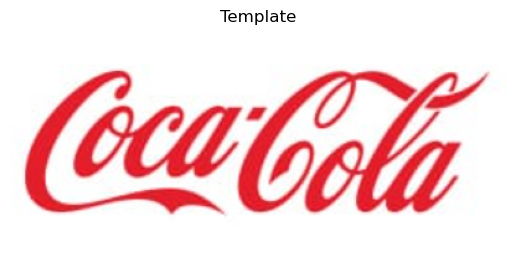

In [3]:
# Cargar el template
template=cv2.imread('template/pattern.png')
template_rgb=cv2.cvtColor(template,cv2.COLOR_BGR2RGB)
plt.imshow(template_rgb)
plt.title('Template')
plt.axis('off')
plt.show()

Escalas Ideales - Imagen: 0.9, Escalas Ideales - Template: 0.5


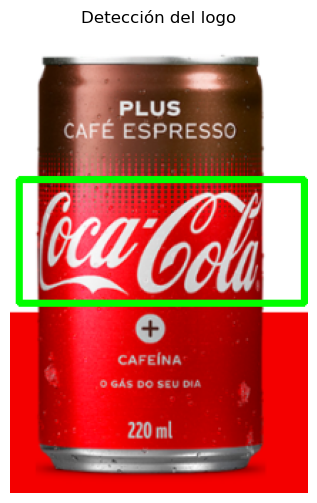

In [4]:
image_path = 'images/coca_logo_2.png'
template_path = 'template/pattern.png'

img_rgb = cv2.imread(image_path)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread(template_path, 0)

# aplico canny para detectar bordes
low_thresh = 50
high_thresh = 200
template_edges = cv2.Canny(template, low_thresh, high_thresh)
img_edges = cv2.Canny(img_gray, low_thresh, high_thresh)

best_match = None

# probar diferentes escalas para la imagen y el template
for img_scale in np.linspace(0.8, 1.0, 5):  # escalas de la imagen (ajustadas para el tamaño del logo)
    resized_img = imutils.resize(img_gray, width=int(img_gray.shape[1] * img_scale))
    resized_img_edges = cv2.Canny(resized_img, low_thresh, high_thresh)

    for template_scale in np.linspace(0.5, 1.0, 5):  # escalas del template (ajustadas para el tamaño del logo)
        resized_template = imutils.resize(template_edges, width=int(template.shape[1] * template_scale))
        if resized_template.shape[0] > resized_img_edges.shape[0] or resized_template.shape[1] > resized_img_edges.shape[1]:
            continue  # pasar si el template es más grande que la imagen redimensionada

        res = cv2.matchTemplate(resized_img_edges, resized_template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)  #  interesa el valor máximo y la ubicación

        # Comprobar si max_val es el mayor comparado con el valor de otros templates escalados
        if best_match is None or max_val > best_match[0]:
            ideal_img_scale = img_scale
            ideal_template_scale = template_scale
            h, w = resized_template.shape
            best_match = [max_val, max_loc, ideal_img_scale, ideal_template_scale]

print(f"Escalas Ideales - Imagen: {ideal_img_scale}, Escalas Ideales - Template: {ideal_template_scale}")

top_left = best_match[1]
bottom_right = (top_left[0] + w, top_left[1] + h)
resized_img_rgb = imutils.resize(img_rgb, width=int(img_rgb.shape[1] * ideal_img_scale))
cv2.rectangle(resized_img_rgb, top_left, bottom_right, (0, 255, 0), 3) 
cv2.imwrite('matched_resized.jpg', resized_img_rgb)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(resized_img_rgb, cv2.COLOR_BGR2RGB))
plt.title('Detección del logo')
plt.axis('off') 
plt.show()


### Detección del logo en todas las imágenes

In [5]:
def match_logo(image_path, template_path, low_thresh=50, high_thresh=200):
    img_rgb = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    template = cv2.imread(template_path, 0)

    # Aplicar detección de bordes con Canny
    template_edges = cv2.Canny(template, low_thresh, high_thresh)

    best_match = None

    #iterar sobre diferentes escalas de la imagen a 2 veces su tamaño original
    for img_scale in np.linspace(0.05, 2, 100)[::-1]:
        resized_img = imutils.resize(img_gray, width=int(img_gray.shape[1] * img_scale))
        resized_img_edges = cv2.Canny(resized_img, low_thresh, high_thresh)

        #iterar sobre diferentes escalas del template
        for template_scale in np.linspace(0.8, 1.0, 5):
            resized_template = imutils.resize(template_edges, width=int(template.shape[1] * template_scale))
            
            # si el tamaño del template es mayor que el de la imagen redimensionada sigue 
            if resized_template.shape[0] > resized_img_edges.shape[0] or resized_template.shape[1] > resized_img_edges.shape[1]:
                continue  

            res = cv2.matchTemplate(resized_img_edges, resized_template, cv2.TM_CCOEFF_NORMED)
            _, max_val, _, max_loc = cv2.minMaxLoc(res)

            # actualiza el mejor match si el actual es mejor
            if best_match is None or max_val > best_match[0]:
                ideal_img_scale = img_scale
                ideal_template_scale = template_scale
                h, w = resized_template.shape
                best_match = [max_val, max_loc, ideal_img_scale, ideal_template_scale]

    top_left = best_match[1]
    bottom_right = (top_left[0] + w, top_left[1] + h)
    resized_img_rgb = imutils.resize(img_rgb, width=int(img_rgb.shape[1] * ideal_img_scale))
    cv2.rectangle(resized_img_rgb, top_left, bottom_right, (0, 255, 0), 3)

    return resized_img_rgb, ideal_img_scale, ideal_template_scale


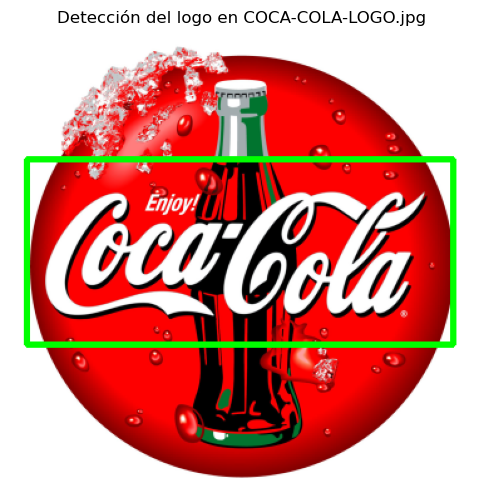

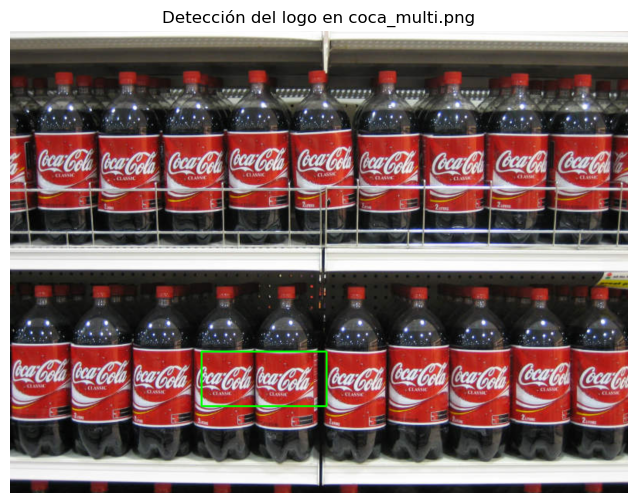

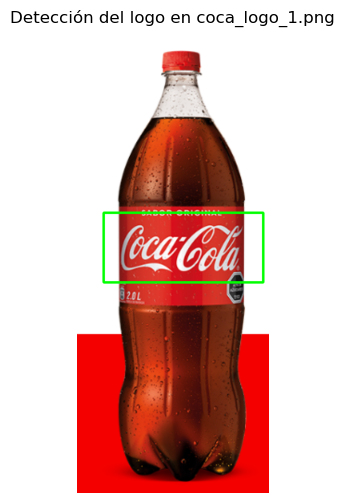

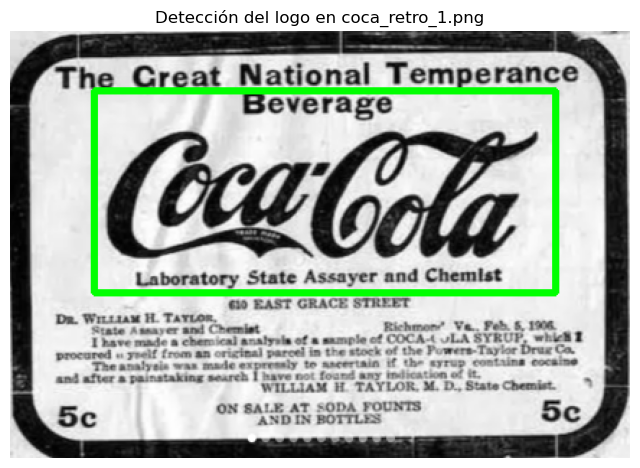

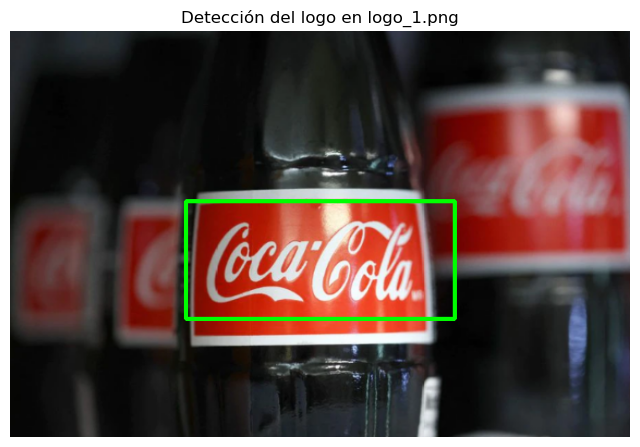

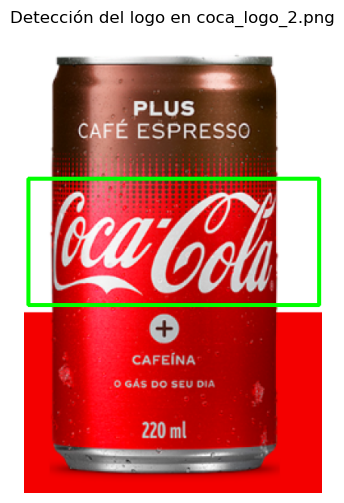

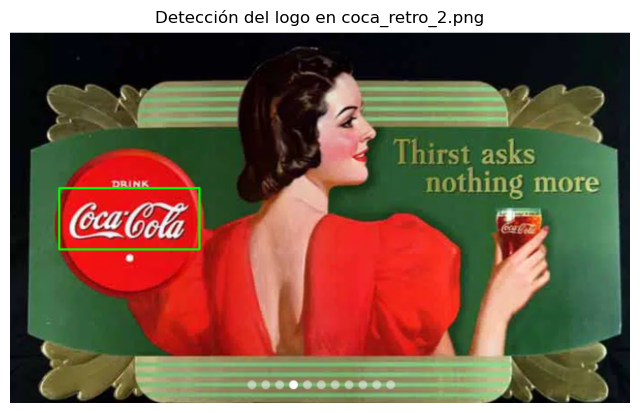

In [6]:

input_folder = 'images/'

# umbrales para la detección de bordes
low_thresh = 50
high_thresh = 200

template_path = 'template/pattern.png'

image_files = os.listdir(input_folder)

for image_file in image_files:
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(input_folder, image_file)

        matched_img, _, _ = match_logo(image_path, template_path, low_thresh, high_thresh)

        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Detección del logo en {image_file}')
        plt.axis('off')
        plt.show()

#### Detección de multiples logos en una misma imágen

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

threshold = 0.085 # umbral para la detección de logos

#  detectar múltiples logos en una imagen
def match_multi_logo(image_path, template_path, scale_range=(0.5, 6), scale_steps=100, threshold=threshold):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    
    template_height, template_width = template.shape[:2]
    template_edges = cv2.Canny(template, 100, 200)
    
    # almacenar los valores de coincidencia, ubicaciones y escalas
    match_vals = []
    match_locs = []
    match_scales = []
    
    # se aplica el detector de bordes de Canny a la imagen original
    image_edges = cv2.Canny(image_gray, 100, 200)
    
    # Iterar sobre las escalas deseadas de manera inversa
    for scale in np.linspace(scale_range[0], scale_range[1], scale_steps)[::-1]:
        new_width = int(image_gray.shape[1] * scale)
        resized = cv2.resize(image_gray, (new_width, int(image_gray.shape[0] * scale)))
        
        # Si la imagen redimensionada es más chica que el template, salir del bucle
        new_h, new_w = resized.shape[:2]
        if new_h < template_height or new_w < template_width:
            break
        
        # bordes de Canny a la imagen redimensionada
        resized_edges = cv2.Canny(resized, 100, 200)
        result = cv2.matchTemplate(resized_edges, template_edges, cv2.TM_CCOEFF_NORMED)
        
        location = np.where(result >= threshold)
        
        for loc in zip(*location[::-1]):
            match_vals.append(result[loc[1], loc[0]])  
            match_locs.append(loc)  
            match_scales.append(scale)  # guardar la escala utilizada
    
    for loc, scale in zip(match_locs, match_scales):
        X, Y = loc
        X = int(X / scale)
        Y = int(Y / scale)
        Xf = int(X + template_width / scale)
        Yf = int(Y + template_height / scale)
        cv2.rectangle(image, (X, Y), (Xf, Yf), (0, 255, 0), 2)
    
    return image


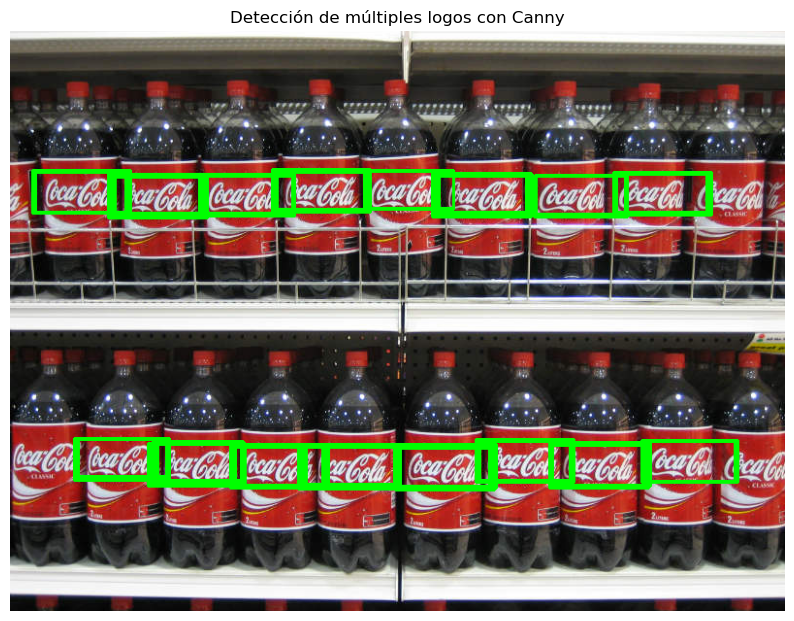

In [117]:
template_path = 'template/pattern.png'
image_path = 'images/coca_multi.png'

matched_image = match_multi_logo(image_path, template_path)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title('Detección de múltiples logos con Canny')
plt.axis('off')
plt.show()

### Detección de multiples logos en una imágen, para todas las imágenes

In [30]:
# NMSBoxes no está disponible en el módulo cv2.dnn. Acá dejo una versión manual de Non-Maximum Suppression (NMS) para eliminar detecciones redundantes y mantener solo las más significativas.
# Implementación básica de NMS para eliminar las detecciones redundantes:

# Calcular el área de cada rectángulo de detección.
# Ordenar los rectángulos por sus valores de coincidencia.
# Iterar sobre los rectángulos, eliminando aquellos que se solapen significativamente con uno de mayor valor.
def non_max_suppression(boxes, scores, threshold):
    if len(boxes) == 0:
        return []

    # Convertir boxes a formato numpy array para mayor eficiencia
    boxes = np.array(boxes)
    scores = np.array(scores)

    # Coordenadas de las esquinas de los rectángulos
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Áreas de los rectángulos
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Ordenar los rectángulos por sus scores (de mayor a menor)
    order = scores.argsort()[::-1]

    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / areas[order[1:]]

        order = order[np.where(overlap <= threshold)[0] + 1]

    return keep

def match_multi_logo(image_path, template_path, scale_range=(0.2, 3), scale_steps=100, threshold=0.085, nms_threshold=0.5):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    
    template_height, template_width = template.shape[:2]
    template_edges = cv2.Canny(template, 50, 150)
    
    match_vals = []
    match_locs = []
    match_scales = []
    
    for scale in np.linspace(scale_range[0], scale_range[1], scale_steps)[::-1]:
        new_width = int(image_gray.shape[1] * scale)
        resized = cv2.resize(image_gray, (new_width, int(image_gray.shape[0] * scale)))
        
        new_h, new_w = resized.shape[:2]
        if new_h < template_height or new_w < template_width:
            break
        
        resized_edges = cv2.Canny(resized, 100, 200)
        result = cv2.matchTemplate(resized_edges, template_edges, cv2.TM_CCOEFF_NORMED)
        
        location = np.where(result >= threshold)
        
        for loc in zip(*location[::-1]):
            match_vals.append(result[loc[1], loc[0]])  
            match_locs.append((loc[0], loc[1], loc[0] + template_width, loc[1] + template_height))  
            match_scales.append(scale)  
    
    keep_indices = non_max_suppression(match_locs, match_vals, nms_threshold)
    
    for i in keep_indices:
        scale = match_scales[i]
        x1, y1, x2, y2 = match_locs[i]
        X, Y = int(x1 / scale), int(y1 / scale)
        Xf, Yf = int(x2 / scale), int(y2 / scale)
        cv2.rectangle(image, (X, Y), (Xf, Yf), (0, 255, 0), 2)
    
    return image

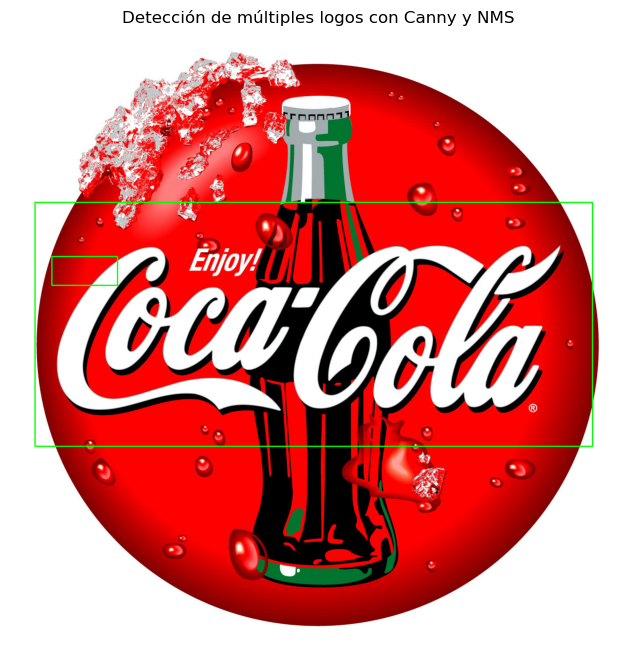

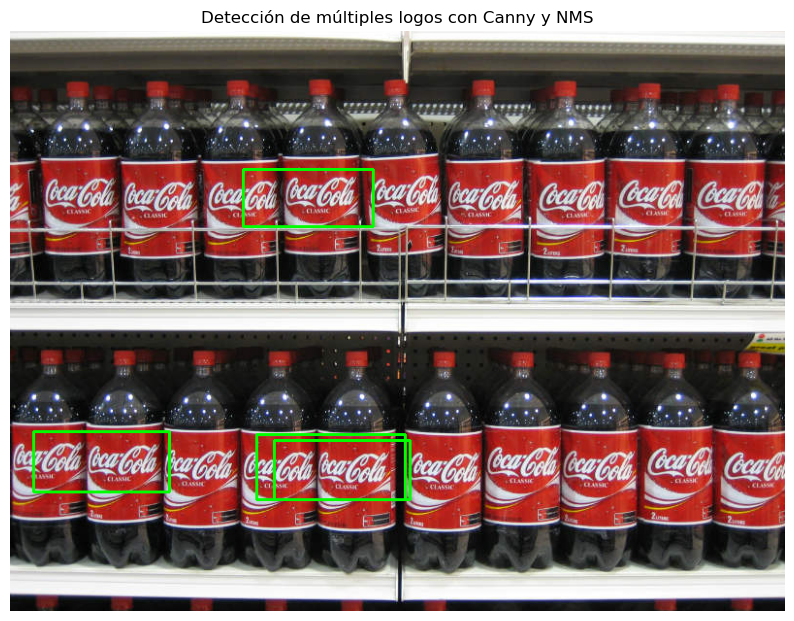

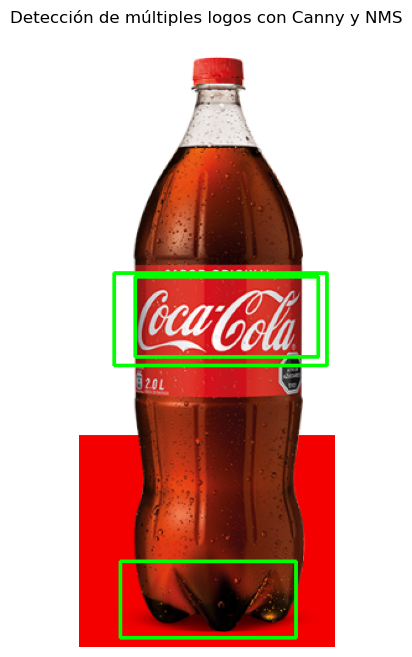

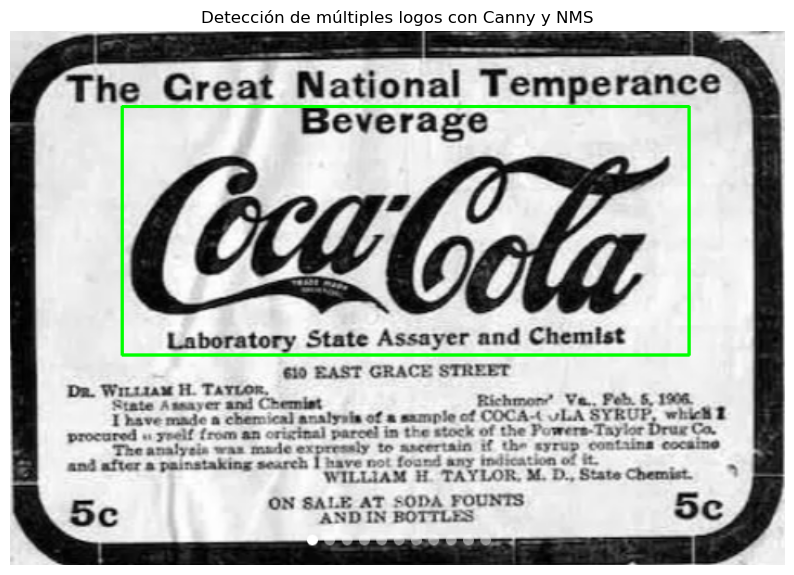

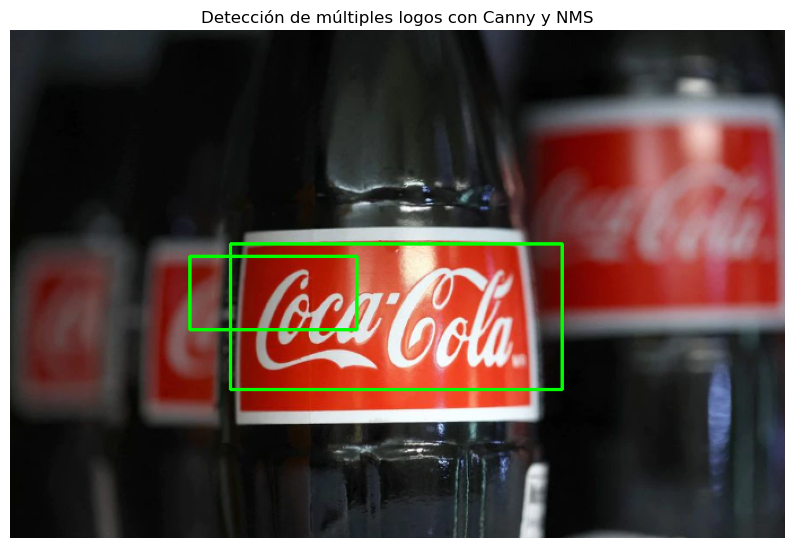

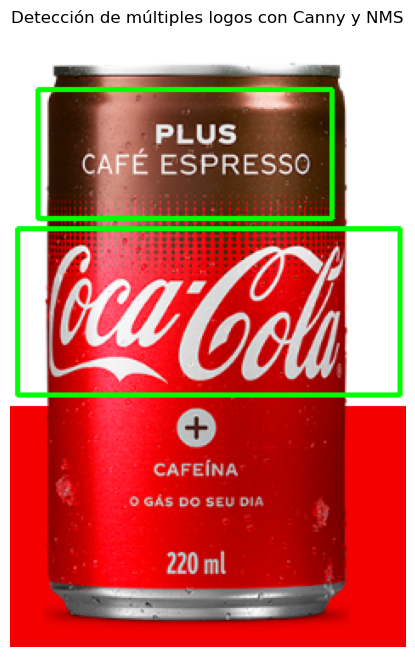

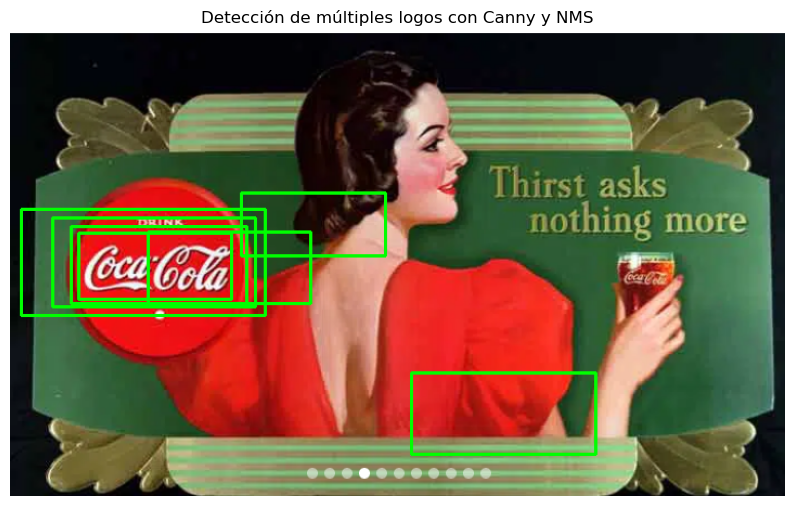

In [31]:
input_folder = 'images'
template_path = 'template/pattern.png'

image_files = os.listdir(input_folder)

for image_file in image_files:
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(input_folder, image_file)

        matched_image = match_multi_logo(image_path, template_path, scale_range=(0.05, 3), threshold=0.074, nms_threshold=0.5) # fui probando con distintas escalas y umbrales, estos fueron con mejor resultado.

        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
        plt.title('Detección de múltiples logos con Canny y NMS')
        plt.axis('off')
        plt.show()

### Conclusión

Durante la prueba de detección del logo, experimenté con varios umbrales y ajusté las escalas de las imágenes. Además, implementé Non-Maximum Suppression (NMS) para eliminar detecciones redundantes. A pesar de estos esfuerzos, aún enfrenté dificultades significativas para filtrar las detecciones falsas positivas.

Para mejorar la precisión, se podrían considerar las siguientes mejoras:

Experimentar con técnicas avanzadas de filtrado y post-procesamiento, como el uso de redes neuronales convolucionales (CNNs).
Ajustar los parámetros del algoritmo de template matching y los umbrales de detección para optimizar el rendimiento.
Utilizar métodos de aprendizaje automático para aprender patrones más complejos y mejorar la precisión de las detecciones.
Investigar el uso de características adicionales o descriptores para mejorar la discriminación entre detecciones válidas y falsas.
En conclusión, aunque la detección de plantillas es un desafío, la combinación de métodos avanzados y ajustes finos puede llevar a mejoras significativas en la precisión.

